# Evaluate Model

1. Using different values to improve our model
    - Alpha
    - Beta
    - Number of Iterations
    - Change in Dataset

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# data here is filled with growth trendline analysis using excel and 0's where places are obvious
df = pd.read_csv("Data/Singapore_Covid_Data_csv.csv")
display(df)

,location,date,new_cases_smoothed_per_million,total_cases_per_million,new_deaths_smoothed_per_million,reproduction_rate,new_tests_smoothed_per_thousand,positive_rate,people_fully_vaccinated_per_hundred,stringency_index
0,Singapore,1/3/2020,0.445,0.183,0.000,0.56,0.000,0.000,0.000,30.56
1,Singapore,2/3/2020,0.498,0.550,0.000,0.54,0.000,0.000,0.000,30.56
2,Singapore,3/3/2020,0.498,0.550,0.000,0.53,0.000,0.000,0.000,30.56
3,Singapore,4/3/2020,0.445,0.733,0.000,0.57,0.000,0.000,0.000,30.56
4,Singapore,5/3/2020,0.629,0.917,0.000,0.73,0.000,0.000,0.000,30.56
...,...,...,...,...,...,...,...,...,...,...
609,Singapore,31/10/2021,673.998,15193.634,0.288,0.97,4.130,0.163,86.405,44.44
610,Singapore,1/11/2021,655.556,15496.186,0.367,0.94,4.130,0.159,86.445,44.44
611,Singapore,2/11/2021,661.293,15760.782,0.419,0.92,3.976,0.166,86.485,44.44
612,Singapore,3/11/2021,617.050,16116.327,0.472,0.90,3.822,0.161,86.525,44.44


## Start of manual ML coding

In [163]:
def normalize_z(df):
    return ((df - df.mean(axis=0))/df.std(axis=0))

def get_features_targets(df, feature_names, target_names):
    # get df of selected features
    df_feature = df[feature_names]
    # get df of selected targets
    df_target = df[target_names]
    return df_feature, df_target

def prepare_feature(df_feature):
    # number of columns in the dataframe
    cols = len(df_feature.columns)
    # convert df to numpy
    feature = df_feature.to_numpy().reshape(-1,cols)
    array = np.concatenate((np.ones((feature.shape[0],1)), feature), axis = 1)
    return array

def prepare_target(df_target):
    cols = len(df_target.columns)
    target = df_target.to_numpy().reshape(-1,cols)
    return target

def predict(df_feature, beta):
    df_feature = normalize_z(df_feature)
    preped_feature = prepare_feature(df_feature)
    return predict_norm(preped_feature, beta)

def predict_norm(X, beta):
    return np.matmul(X,beta)

def split_data(df_feature, df_target, random_state=100, test_size=0.3):
    ###BEGIN SOLUTION
    indexes = df_feature.index
    if random_state != None:
        np.random.seed(random_state)
    k = int(test_size * len(indexes))
    test_index = np.random.choice(indexes, k, replace=False)
    indexes = set(indexes)
    test_index = set(test_index)
    train_index = indexes - test_index
    # the above indexes just helps you to get random indexes within the entire data
    df_feature_train = df_feature.loc[train_index, :]
    df_feature_test = df_feature.loc[test_index, :]
    df_target_train = df_target.loc[train_index, :]
    df_target_test = df_target.loc[test_index, :]
    
    return df_feature_train, df_feature_test, df_target_train, df_target_test
  
def r2_score(y, ypred):
    ss_res = np.sum((y-ypred)**2)
    y_mean = np.mean(y)
    ss_tot = np.sum((y-y_mean)**2)
    r_2 = (1-(ss_res/ss_tot))
    return r_2

def mean_squared_error(target, pred):
    num_data = target.shape[0]
    return (1/num_data)*(np.sum((target-pred)**2))

def compute_cost(X, y, beta): #beta is weighted values, in this case it is just choosen from random values
    J = 0
    number_of_samples = X.shape[0]
    error = np.matmul(X, beta) - y
    error_sq = np.matmul(error.T, error)
    J = (1)/(2*number_of_samples) * error_sq 
    J = J[0][0]
    return J

def gradient_descent(X, y, beta, alpha, num_iters):
    number_of_samples = X.shape[0]
    J_storage = []
    for i in range(num_iters):
        derivative_error = (1/(number_of_samples)) * np.matmul(X.T, (np.matmul(X, beta) - y))
        beta = beta - alpha *  derivative_error
        J_storage.append(compute_cost(X, y, beta))
    return beta, J_storage

In [164]:
# single function to make the model
# @args
# 1. alpha-value (step for gradient descent)
# 2. beta (starting beta values for gradient descent)
# 3. iterations (number of iterations of gradient descent)
# 4. start (starting row)
# 5. end (last row)
# @return
# r^2 and mse values

def make_model(alpha, beta, iterations,start,end):
    # Extract the features and the target
    df_features_original_train, df_target = get_features_targets(df.loc[start:end,:],["new_cases_smoothed_per_million","total_cases_per_million","new_deaths_smoothed_per_million", "reproduction_rate", "new_tests_smoothed_per_thousand","people_fully_vaccinated_per_hundred","positive_rate"],["stringency_index"])

    # Split the data set into training and test
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features_original_train,df_target,100,0.3)

    # Normalize the features using z normalization
    df_features_train_z = normalize_z(df_features_train)

    # Change the features and the target to numpy array using the prepare functions
    X = prepare_feature(df_features_train_z)
    target = prepare_target(df_target_train)

    beta = np.ones((8,1))

    # Call the gradient_descent function
    beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

    # call the predict() method
    pred = predict(df_features_test,beta)

    target = prepare_target(df_target_test)
    r2 = r2_score(target,pred)
    mse = mean_squared_error(target, pred)
    # print(f"r^2 value = {r2}, mean squared error = {mse}")
    return r2, mse

In [165]:
df = pd.read_csv("Data/Singapore_Covid_Data_csv.csv")
## include entire dataset, consisting of unrelated values
make_model(0.01,np.zeros((8, 1)),500, 0, None)
## change in dataset to include only suitable dataset
make_model(0.01,np.zeros((8, 1)),500, 46, None)

(0.8275510365654146, 13.148411077842304)

In [166]:
beta_range = [np.zeros((8,1)),np.ones((8,1)),np.full((8,1),5),np.full((8,1),10)]
# changing beta values makes no difference to r2 and mse values
for i in beta_range:
    make_model(0.01,i,500, 46, None)

[Text(0.5, 1.0, 'Model Metrics against number of iterations'),
 Text(0, 0.5, '')]

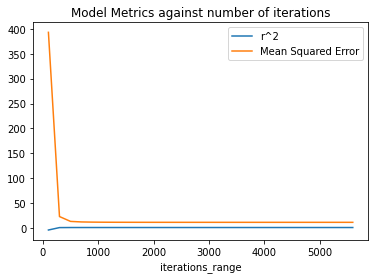

In [172]:
iterations_range = [100,300,500,700,900,1100,1300,1500,1700,1900,2100,2300,2500,2700,2900,3100,3300,3500,3700,3900,4100,4300,4600,4800,5000,5200,5400,5600]
# change in number of iterations
r2_value_range = []
mse_value_range = []
for i in iterations_range:
    r2_value, mse_value = make_model(0.01,np.zeros((8,1)), i, 46, None)
    r2_value_range.append(r2_value)
    mse_value_range.append(mse_value)
data = pd.DataFrame(list(zip(iterations_range, r2_value_range, mse_value_range)))
data.columns = ["iterations_range", "r2_value_range", "mse_value_range"]
sns.lineplot(data = data,x="iterations_range", y="r2_value_range", label = "r^2")
sns.lineplot(data = data,x="iterations_range", y="mse_value_range", label = "Mean Squared Error").set(title="Model Metrics against number of iterations", ylabel = "")

# r^2 and mse values become significantly more accurate after 300 iterations
# to reach mse_value with accuracy of up to 3 d.p, you will need to reach 5200 iterations


[Text(0.5, 1.0, 'Model Metrics against alpha value'), Text(0, 0.5, '')]

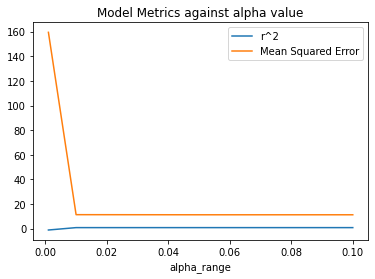

In [173]:
## test for changes to alpha value
alpha_range = [0.001, 0.01, 0.05, 0.1]
r2_value_range = []
mse_value_range = []
for i in alpha_range:
    r2_value, mse_value = make_model(i,np.zeros((8,1)),1500, 46, None)
    r2_value_range.append(r2_value)
    mse_value_range.append(mse_value)
data = pd.DataFrame(list(zip(alpha_range, r2_value_range, mse_value_range)))
data.columns = ["alpha_range", "r2_value_range", "mse_value_range"]
sns.lineplot(data = data,x="alpha_range", y="r2_value_range", label = "r^2")
sns.lineplot(data = data,x="alpha_range", y="mse_value_range", label = "Mean Squared Error").set(title="Model Metrics against alpha value", ylabel = "")


# r^2 and mse values become significantly more accurate after 0.01 alpha value
# to reach mse_value with accuracy of up to 3 d.p, you will need to reach 5200 iterations
